In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from matplotlib import rcParams

import matplotlib.patches as patches
from math import ceil

In [2]:
DATA_FOLDER = 'rsna-pneumonia-detection-challenge/'
random_seed = 42

np.random.seed(random_seed)
torch.manual_seed(random_seed);

# Loading the datasets

In [3]:
# Importing the datasets
label_data = pd.read_csv(DATA_FOLDER + 'stage_2_train_labels.csv')
class_info = pd.read_csv(DATA_FOLDER + 'stage_2_detailed_class_info.csv').drop_duplicates()
label_data.shape

(30227, 6)

In [4]:
# Merge the two datasets
label_data = label_data.merge(class_info, on='patientId')
label_data.shape

(30227, 7)

In [5]:
label_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


# Loading the images

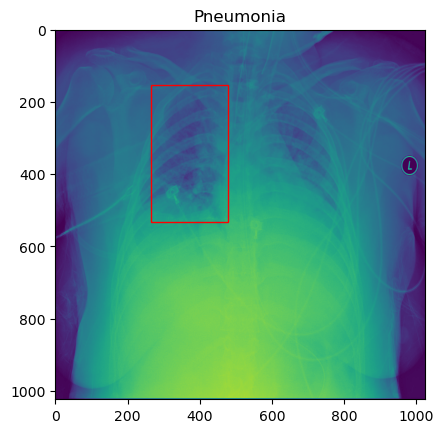

In [6]:
idx = 4

train_images = DATA_FOLDER + 'stage_2_train_images/'
image_name = label_data['patientId'][idx] + '.dcm'

ds = dcmread(train_images + image_name)
box = [label_data['x'][idx], label_data['y'][idx], label_data['width'][idx], label_data['height'][idx]]
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots(1)
ax.imshow(ds.pixel_array)
ax.add_patch(rect)
plt.title('Pneumonia' if label_data['Target'][idx] == 1 else 'No Pneumonia')
plt.show()

# Main pipeline

In [7]:
columns = ['patientId', 'Target']
all_data = label_data

label_data = label_data.filter(columns)
label_data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [8]:
all_data.shape

(30227, 7)

## Splitting the data

In [9]:
train_labels, test_labels = train_test_split(label_data.values, test_size=0.2, random_state=random_seed)
train_labels, val_labels = train_test_split(train_labels, test_size=0.25, random_state=random_seed)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(18135, 2)
(6046, 2)
(6046, 2)


In [10]:
train_f = DATA_FOLDER + 'stage_2_train_images/'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]
test_paths = [os.path.join(train_f, image[0]) for image in test_labels]

print(len(train_paths))
print(len(val_paths))

18135
6046


In [11]:
img_dcm = dcmread(f'{train_paths[20]}.dcm')
img_np = img_dcm.pixel_array
shape = img_np.shape

In [12]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

# imshow()

## Transformations

In [13]:
old_size = 1024
new_size = 224

In [14]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.Resize(new_size),
    transforms.ToTensor()])

In [15]:
shape = (old_size, old_size)
new_shape = (new_size, new_size)

ratio_w = new_size / old_size
ratio_h = new_size / old_size

In [16]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image)
        
        if self.labels is not None:
            label = self.labels[index][1]
        else:
            label = None
        
        if self.transform is not None:
            image = self.transform(image)

        name = self.paths[index].split("/")[-1]
        FIL = all_data[all_data['patientId']==name]
        #print("From the datset loader, name", name)
        centers_x = (FIL['x'].values + FIL['width'].values / 2) / old_size
        centers_y = (FIL['y'].values + FIL['height'].values / 2) / old_size
        
        new_widths = FIL['width'].values / old_size
        new_heights = FIL['height'].values / old_size
        
        boxes = [[centers_x[j], centers_y[j], new_widths[j], new_heights[j]] for j in range(len(FIL))]
            
        return image, label, boxes, name
    
    def __len__(self):
        
        return len(self.paths)

## Training and validation dataloader

In [17]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
test_dataset = Dataset(test_paths, test_labels, transform=transform)

## Saving the images and labels

In [18]:
data_folder = 'datasets/'

### For detection

In [19]:
detection_folder = data_folder + 'pneumonia_detection/'

images_folder =  detection_folder + 'images/'
labels_folder = detection_folder + 'labels/'

train_folder = 'train/'
val_folder = 'val/'
test_folder = 'test/'


Path(images_folder + train_folder).mkdir(parents=True, exist_ok=True)
Path(images_folder + val_folder).mkdir(parents=True, exist_ok=True)
Path(images_folder + test_folder).mkdir(parents=True, exist_ok=True)

Path(labels_folder + train_folder).mkdir(parents=True, exist_ok=True)
Path(labels_folder + val_folder).mkdir(parents=True, exist_ok=True)
Path(labels_folder + test_folder).mkdir(parents=True, exist_ok=True)

In [20]:
def save_files_detection(dataset, folder):
    for i, (image, label, boxes, name) in tqdm(enumerate(dataset), total=len(dataset)):
        if label == 1:
            save_image(image, images_folder + folder + f'{name}.png')
            with open(labels_folder + folder + f'{name}.txt', 'w') as f:
                for box in boxes:
                    f.write(f'0 {box[0]} {box[1]} {box[2]} {box[3]}\n')

In [ ]:
save_files_detection(train_dataset, train_folder)
save_files_detection(val_dataset, val_folder)
save_files_detection(test_dataset, test_folder)

  4%|▍         | 792/18135 [00:14<04:54, 58.95it/s]

### For classification

In [ ]:
classification_folder = data_folder + 'pneumonia_classification/'

train_folder = 'train/'
val_folder = 'val/'
test_folder = 'test/'

healthy = '0/'
pneumonia = '1/'


Path(classification_folder + train_folder + healthy).mkdir(parents=True, exist_ok=True)
Path(classification_folder + val_folder + healthy).mkdir(parents=True, exist_ok=True)
Path(classification_folder + test_folder + healthy).mkdir(parents=True, exist_ok=True)

Path(classification_folder + train_folder + pneumonia).mkdir(parents=True, exist_ok=True)
Path(classification_folder + val_folder + pneumonia).mkdir(parents=True, exist_ok=True)
Path(classification_folder + test_folder + pneumonia).mkdir(parents=True, exist_ok=True)

In [ ]:
def save_files_classification(dataset, folder):
    for i, (image, label, _, name) in tqdm(enumerate(dataset), total=len(dataset)):
        if label == 0:
            save_image(image, classification_folder + folder + healthy + f'{name}.png')
        else:
            save_image(image, classification_folder + folder + pneumonia + f'{name}.png')

In [ ]:
save_files_classification(train_dataset, train_folder)
save_files_classification(val_dataset, val_folder)
save_files_classification(test_dataset, test_folder)

### For submission

In [ ]:
submission_folder = data_folder + 'pneumonia_inference/'
submission_images_folder = submission_folder + 'images/'

Path(submission_images_folder).mkdir(parents=True, exist_ok=True)
    
def save_submission_files(dataset, folder):
    for i, (image, _, _, name) in tqdm(enumerate(dataset), total=len(dataset)):
        save_image(image, folder + f'{name}.png')

In [ ]:
inference_f = DATA_FOLDER + 'stage_2_test_images/'

inference_paths = [os.path.join(inference_f, image.split('.')[0]) for image in os.listdir(inference_f)]
inference_dataset = Dataset(inference_paths, None, transform=transform)

In [ ]:
save_submission_files(inference_dataset, submission_images_folder)